In [ ]:
# libraries

import numpy as np
import pandas as pd
import scipy.stats as stat
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import newton
from scipy.optimize import minimize
import scipy.optimize as optimize
from scipy.optimize import least_squares as lsq
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from sklearn.linear_model import *
import matplotlib.gridspec as gridspec

## Black Scholes Formula

In [ ]:
def call_black(F0, K, T, r, sigma):
    """
    Calculate the price of a European call option on a futures contract using Black's formula.

    Parameters:
    F0 : float
        The initial futures price.
    K : float
        The strike price of the option.
    T : float
        The time to maturity of the option in years.
    r : float
        The annual risk-free interest rate.
    sigma : float
        The volatility of the underlying asset.

    Returns:
    float
        The price of the call option.
    """
    d1 = (np.log(F0 / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d0 = d1 - sigma * np.sqrt(T)

    call_price = np.exp(-r * T) * (F0 * norm.cdf(d1) - K * norm.cdf(d0))

    return call_price

## Clewlow-Strickland Model

### Options on Forwards and Futures : 1F Model

For an European option with strike $K$ and that matures at time $T$ on a forward contract that matures at time $s$. By deriving the price at time $t$, the European call has the price :
\begin{align*} C(t,F(t,s),K, T) = \mathbb{E}[P(t,T) max(0,F(T,s) -K)] \end{align*}


In [ ]:
 def one_factor_call(F, K, t, T,s,r,sigma,alpha):

    """
    Calculate the price of a European call option on a forward contract using adjusted formulas.

    Parameters:
    - forward_price: Forward price F(t, s)
    - strike_price: Strike price K of the option
    - current_time: Current time t
    - option_maturity: Maturity time T of the option
    - forward_maturity: Maturity time s of the forward contract. (usually we consider s = T)
    - risk_free_rate: Risk-free interest rate r
    - volatility: Volatility of the forward price
    - alpha: Decay factor

    Returns:
    - call_option_price: The price of the European call option

    """
    time_to_maturity = T - t
    w = (sigma**2 * (np.exp(-2 * alpha * (s - T)) - np.exp(-2 * alpha * (s - t)))) / (2 * alpha)
    w_sqrt = np.sqrt(w)
    h = (np.log(F /K) + 0.5 * w) / w_sqrt
    discount_factor = np.exp(-r * time_to_maturity)
    C = discount_factor * (F * norm.cdf(h) - K * norm.cdf(h - w_sqrt))

    return C

In [ ]:
# example

F = 105
K = 100
t = 0
T = 1
s = 1.5
r = 0.05
sigma = 0.2
alpha = 0.3

one_factor_call(F,K,t,T,s,r, sigma, alpha)

8.485587791044209

In [ ]:
# test benchmark : prices

def commo_cs1f_callmatrix(F, K, T, B, sigma, alpha):
    c_prices = np.zeros((len(F), len(K)))
    for i, f in enumerate(F):
        for j, k in enumerate(K):
            c_prices[i, j] = one_factor_call(f, k, 0, T[i], T[i], -np.log(B[i])/T[i], sigma, alpha)
    return c_prices

F = np.array([80, 85, 102, 103])
K = np.array([85, 90, 100, 110, 105])
T = np.array([1, 3, 6, 12]) / 12
r = 0.02
sigma = 0.55
alpha = 0.31

B = np.exp(-r * T)

c_price = commo_cs1f_callmatrix(F, K, T, B, sigma, alpha)

c_price

array([[ 3.02831578,  1.73419977,  0.48601671,  0.11416331,  0.24021552],
       [ 8.90455897,  6.89052959,  3.98394601,  2.21610293,  2.98401042],
       [23.29571564, 20.34155841, 15.32004062, 11.38104611, 13.22458583],
       [27.47662387, 24.81865858, 20.17560295, 16.34277062, 18.16486067]])

In [ ]:
# implied volatility for one price

def commodity_impliedvol(F, K, T, B, c_price, initial_sigma):
    def objective(sigma):
        def one_factor_call_wrapper(F, K, t, T, s, r, alpha):
            return one_factor_call(F, K, t, T, s, r, sigma, alpha)
        calculated_price = call_black(F, K, T, -np.log(B)/T, sigma)
        return calculated_price - c_price

    try:
        vol = newton(objective, initial_sigma)
    except ValueError:
        vol = np.nan
    return vol

In [ ]:
# test benchmark : implied volatility

def commo_impliedvol(F, K, T, B, c_price, initial_sigma):
    vols = np.zeros_like(c_price)
    for i in range(len(F)):
        for j in range(len(K)):
            def objective(sigma):
                def one_factor_call_wrapper(F, K, t, T, s, r, alpha):
                    return one_factor_call(F, K, t, T, s, r, sigma, alpha)
                calculated_price = call_black(F[i], K[j], T[i], -np.log(B[i])/T[i], sigma)
                return calculated_price - c_price[i, j]
            try:
                vols[i, j] = newton(objective, initial_sigma)
            except ValueError:
                vols[i, j] = np.nan
    return vols

c_vol = commo_impliedvol(F, K, T, B, c_price, sigma)
c_vol

array([[0.54297171, 0.54297171, 0.54297171, 0.54297171, 0.54297171],
       [0.52935998, 0.52935998, 0.52935998, 0.52935998, 0.52935998],
       [0.5100041 , 0.5100041 , 0.5100041 , 0.5100041 , 0.5100041 ],
       [0.47480354, 0.47480354, 0.47480354, 0.47480354, 0.47480354]])

### Options on Foward and Futures : Multi-Factor Model

We define the volatitlity function $\sigma(u, s, \alpha, \beta)$ which is a simple and usual form for modelling volatility according to the formula 2.7 in Clewlow, Strickland, 1999 : $\sigma(u, s, \alpha, \beta) = \beta e^{-\alpha(s-u)}$. We also recall that $ w = \sum_{i = 1}^n \{ \int_t^T \sigma_i(u,s)^2 du \} $.

In [ ]:
def sigma(u, s, alpha, beta):
    return beta * np.exp(-alpha * (s - u))

def compute_w(t, T, s, alpha, beta):
    """
    Compute the accumulated variance w
    n number of factors in the model
    """
    w = 0
    for i in range(len(alpha)):
        integral, _ = quad(lambda u: sigma(u, s, alpha[i], beta[i])**2, t, T) # quad compute the integral of the square of the volatility
        w += integral
    return w

def multi_factor_call(t, F, K, T, s, r, alpha, beta):
    """
    compute the price of an European call option on a forward contract
    """
    w = compute_w(t, T, s, alpha, beta)

    # Avoid division by zero
    if w == 0:
        print("Warning: w is zero, returning NaN")
        return np.nan

    h = (np.log(F/K) + 0.5 * w) / np.sqrt(w)
    discount_factor = np.exp(-r * (T - t))
    C = discount_factor * (F * norm.cdf(h) - K * norm.cdf(h - np.sqrt(w)))

    return C

In [ ]:
# example

t = 0
F = 105
K = 100
T = 1
s = 1.5
r = 0.05
alpha = [0.3]
beta = [0.2]

# Calculate the call option price

multi_factor_call(t, F, K, T, s, r, alpha, beta)

8.485587791044209

In [ ]:
# implied volatilty for one price

def implied_volatility(C, F, K, T, r):
    objective = lambda sigma: call_black(F, K, T, r, sigma) - C
    return brentq(objective, 0.001, 2.0)  # search between 0.1% and 200% volatility

def commodity_impliedvol_multi(F, K, T, B, beta, alpha):
    t = 0  # Starting time
    r = -np.log(B)/T  # Continuously compounded risk-free rate
    C, w = multi_factor_forward(t, F, K, T, T, r, beta, alpha)
    if w > 0:
        implied_vol = implied_volatility(C, F, K, T, r)
    else:
        implied_vol = np.nan
    return implied_vol

In [ ]:
# test benchmark : prices

F = np.array([80, 85, 102, 103])
K = np.array([85, 90, 100, 110, 105])
T = np.array([1, 3, 6, 12]) / 12
r = 0.02
alpha = [0.65, 0.25]
beta = [0.89, 0.21]

B = np.exp(-r * T)

def commo_cs2f_callmatrix(F, K, T, B, alpha, beta):
    c_prices = np.zeros((len(F), len(K)))
    for i, f in enumerate(F):
        for j, k in enumerate(K):
            c_prices[i, j] = multi_factor_call(0, f, k, T[i], T[i], -np.log(B[i])/T[i], alpha, beta)
    return c_prices

c_price_multi =  commo_cs2f_callmatrix(F, K, T, B, beta, alpha)

c_price_multi

array([[ 4.19212041,  2.74770286,  1.08158973,  0.38639054,  0.65342288],
       [10.63009273,  8.63178628,  5.5826557 ,  3.53698815,  4.45350076],
       [24.88753859, 22.079804  , 17.24943909, 13.36860495, 15.19863664],
       [28.25076165, 25.64732893, 21.08167701, 17.28616743, 19.09429939]])

In [ ]:
# Test benchmark : implied volatility

def multi_factor_forward(t, F, K, T, s, r, alpha, beta):
    w = compute_w(t, T, s, alpha, beta)
    if w == 0:
        print("Warning: w is zero, returning NaN")
        return np.nan, np.nan

    h = (np.log(F / K) + 0.5 * w) / np.sqrt(w)
    discount_factor = np.exp(-r * (T - t))
    C = discount_factor * (F * norm.cdf(h) - K * norm.cdf(h - np.sqrt(w)))
    return C, w


def implied_volatility(C, F, K, T, r):
    objective = lambda sigma: call_black(F, K, T, r, sigma) - C
    return brentq(objective, 0.001, 2.0)  # search between 0.1% and 200% volatility

def commo_cs2f_callmatrix(F, K, T, B, beta, alpha):
    c_prices = np.zeros((len(F), len(K)))
    implied_vols = np.zeros((len(F), len(K)))
    for i, f in enumerate(F):
        for j, k in enumerate(K):
            t = 0  # Starting time
            r = -np.log(B[i])/T[i]  # Continuously compounded risk-free rate
            C, w = multi_factor_forward(t, f, k, T[i], T[i], r, beta, alpha)
            c_prices[i, j] = C
            if w > 0:
                implied_vols[i, j] = implied_volatility(C, f, k, T[i], r)
            else:
                implied_vols[i, j] = np.nan
    return implied_vols

c_vol = commo_cs2f_callmatrix(F, K, T, B, beta, alpha)

c_vol

array([[0.6738524 , 0.6738524 , 0.6738524 , 0.6738524 , 0.6738524 ],
       [0.63272885, 0.63272885, 0.63272885, 0.63272885, 0.63272885],
       [0.5797816 , 0.5797816 , 0.5797816 , 0.5797816 , 0.5797816 ],
       [0.4983637 , 0.4983637 , 0.4983637 , 0.4983637 , 0.4983637 ]])

# Test on the data set

In [ ]:
# import of the data set

def read_data(file_name):
    """
    Set the column date of a dateframe as an index
    """
    data = pd.read_excel(file_name)
    data["Date"] = pd.to_datetime(data.iloc[:,0], format = "%Y/%m/%d")
    data.set_index("Date", inplace = True)
    data.sort_index(inplace=True)

    return data

future = read_data("WTI_Futures_HistoricalDatas.xlsx")
rate = read_data("WTI_Rates_HistoricalDatas.xlsx")
smile = read_data("WTI_Smiles_HistoricalDatas.xlsx")

## Modification of the data set

In [ ]:
# Getting the last observation of each month for Future prices
def extract_last_days(df):
    last_days_df = df.resample('M').last()
    return last_days_df

### Strike

In [ ]:
# We extract K for the last days of each month
K = smile["CL@N 100% MONEYNESS - U/LYING PRICE"]
K_last_days = extract_last_days(K)# divide the implied volatility by 100
K_last_days.head()

Date
2012-12-31    91.82
2013-01-31    97.96
2013-02-28    92.05
2013-03-31    97.49
2013-04-30    93.46
Freq: M, Name: CL@N 100% MONEYNESS - U/LYING PRICE, dtype: float64

### Futures

In [ ]:
# select the corresponding months: 1, 2, 3, 6, 9, 12, 24 (because volatilities from 1 to 24 months are implied)

future = future[["NYM-LIGHT CRUDE OIL TRc1", "NYM-LIGHT CRUDE OIL TRc2", 'NYM-LIGHT CRUDE OIL TRc3',  "NYM-LIGHT CRUDE OIL TRc6", "NYM-LIGHT CRUDE OIL TRc9", "NYM-LIGHT CRUDE OIL TRc12", "NYM-LIGHT CRUDE OIL TRc24"]]

future_last_days = extract_last_days(future)
future_last_days.head()

,NYM-LIGHT CRUDE OIL TRc1,NYM-LIGHT CRUDE OIL TRc2,NYM-LIGHT CRUDE OIL TRc3,NYM-LIGHT CRUDE OIL TRc6,NYM-LIGHT CRUDE OIL TRc9,NYM-LIGHT CRUDE OIL TRc12,NYM-LIGHT CRUDE OIL TRc24
Date,,,,,,,
2012-12-31,91.82,92.27,92.73,93.70,93.60,93.19,91.36
2013-01-31,97.49,97.96,98.41,98.94,97.89,96.45,91.94
2013-02-28,92.05,92.46,92.84,93.20,92.52,91.62,88.51
2013-03-31,97.23,97.49,97.64,96.88,95.37,94.03,90.26
2013-04-30,93.46,93.68,93.67,92.55,91.24,90.20,87.20


### Volatilities

In [ ]:
# volatilities are selected for 1 to 24 months

smile = smile[["CL@N 100% MONEYNESS - IMPLIED VOL 1 MTH.", "CL@N 100% MONEYNESS - IMPLIED VOL 2 MTH.", "CL@N 100% MONEYNESS - IMPLIED VOL 3 MTH.", "CL@N 100% MONEYNESS - IMPLIED VOL 6 MTH.", "CL@N 100% MONEYNESS - IMPLIED VOL 9 MTH.", "CL@N 100% MONEYNESS - IMPLIED VOL 1 YR .", "CL@N 100% MONEYNESS - IMPLIED VOL 2 YR ." ]]

smile_last_days = extract_last_days(smile)/100 # divide the implied volatility by 100
smile_last_days.head()

,CL@N 100% MONEYNESS - IMPLIED VOL 1 MTH.,CL@N 100% MONEYNESS - IMPLIED VOL 2 MTH.,CL@N 100% MONEYNESS - IMPLIED VOL 3 MTH.,CL@N 100% MONEYNESS - IMPLIED VOL 6 MTH.,CL@N 100% MONEYNESS - IMPLIED VOL 9 MTH.,CL@N 100% MONEYNESS - IMPLIED VOL 1 YR .,CL@N 100% MONEYNESS - IMPLIED VOL 2 YR .
Date,,,,,,,
2012-12-31,0.2615,0.2702,0.2772,0.2853,0.2847,0.2643,0.2370
2013-01-31,0.1925,0.2062,0.2176,0.2322,0.2354,0.2313,0.2083
2013-02-28,0.2146,0.2263,0.2350,0.2443,0.2369,0.2284,0.2032
2013-03-31,0.1679,0.1725,0.1752,0.1830,0.1864,0.1858,0.1784
2013-04-30,0.2242,0.2201,0.2189,0.2120,0.2060,0.1999,0.1894


### Rates

In [ ]:
# interpolation to find rates for 2 months and 9 months
rate["US TREASURY CONST MAT 2 MONTH"] = (rate["US TREASURY CONST MAT 1 MONTH"] + rate["US TREASURY CONST MAT 3 MONTH"])/2
rate["US TREASURY CONST MAT 9 MONTH"] = (rate["US TREASURY CONST MAT 6 MONTH"] + rate["US TREASURY CONST MAT 1 YEAR"])/2

# select the corresponding maturity: 1, 2, 3, 6, 9, 12, 24

rate = rate[["US TREASURY CONST MAT 1 MONTH", "US TREASURY CONST MAT 2 MONTH", "US TREASURY CONST MAT 3 MONTH", "US TREASURY CONST MAT 6 MONTH", "US TREASURY CONST MAT 9 MONTH", "US TREASURY CONST MAT 1 YEAR", "US TREASURY CONST MAT 2 YEAR"]]

rate_last_days = extract_last_days(rate)
rate_last_days.head()

,US TREASURY CONST MAT 1 MONTH,US TREASURY CONST MAT 2 MONTH,US TREASURY CONST MAT 3 MONTH,US TREASURY CONST MAT 6 MONTH,US TREASURY CONST MAT 9 MONTH,US TREASURY CONST MAT 1 YEAR,US TREASURY CONST MAT 2 YEAR
Date,,,,,,,
2012-12-31,0.02,0.035,0.05,0.11,0.135,0.16,0.25
2013-01-31,0.04,0.055,0.07,0.12,0.135,0.15,0.27
2013-02-28,0.07,0.090,0.11,0.13,0.150,0.17,0.25
2013-03-31,0.04,0.055,0.07,0.11,0.125,0.14,0.25
2013-04-30,0.03,0.040,0.05,0.09,0.100,0.11,0.22


## 1Factor

### Détermination of the parameter alpha

We calibrate the 1F with a monthly frequency. However, our dataset presents daily data, we need to make a few changes :
- The observed/market monthly call prices is the call price given by the black scholes formula for commodity by using the adequate implied volatility
- The strike $K$ for the month is the mean of daily strikes on the month
- The volatity $\sigma$ for the month is the mean of the daily implied volatities of the month
- The rate $r$ for the month is the mean of the daily rates of the month
- $F_0$ is the price of the first day of the month

### Calibration one factor

In [ ]:
def calibrate_one_factor_call(Fs, Ks, ts, Ts, ss, rs, observed_vols, initial_sigma, initial_alpha):
    def residuals(params):
        sigma, alpha = params
        model_prices = np.array([one_factor_call(F, K, t, T, s, r, sigma, alpha) for F, K, t, T, s, r in zip(Fs, Ks, ts, Ts, ss, rs)])
        observed_prices = np.array([call_black(F, K, T, r, vol) for F, K, T, r, vol in zip(Fs, Ks, Ts, rs, observed_vols)])
        return model_prices - observed_prices

    initial_params = [initial_sigma, initial_alpha]
    bounds = (1e-5, 5.0)
    print("Initial parameters:", initial_params)
    print("Bounds:", bounds)

    result = lsq(residuals, initial_params, bounds=bounds)
    sigma_cal, alpha_cal = result.x

    return sigma_cal, alpha_cal

In [ ]:
# We're testing on 31 October 2023

# define the parameters
test_date = '2023-10-31'

test_future = np.array(future_last_days.loc[test_date]) # futures prices
test_rate = np.array(rate_last_days.loc[test_date]) # interest rate
test_smile = np.array(smile_last_days.loc[test_date]) # implied volatility
test_K = np.repeat(81.02, len(test_future)) # strike
test_T= np.array([1,2,3,6,9,12,24])/12 # maturity of the call option
test_s = test_T # maturity of the future contract. In general, we set s = T
test_t = np.repeat(0, len(test_future)) # t = 0

# test with the calibration function

# Initial values for calibration
initial_sigma = 0.2
initial_alpha = 0.5

# Performing the calibration function
sigma_cal, alpha_cal = calibrate_one_factor_call(test_future, test_K, test_t, test_T, test_s, test_rate, test_smile, initial_sigma, initial_alpha)
print("Calibrated Sigma:", sigma_cal)
print("Calibrated Alpha:", alpha_cal)

Initial parameters: [0.2, 0.5]
Bounds: (1e-05, 5.0)
Calibrated Sigma: 0.3845358177896765
Calibrated Alpha: 0.5098590379018817


In [ ]:
#Test on all dates

# Definition of the dates to be tested
test_dates = future_last_days.index.unique()

# Creating lists to store results
calibrated_sigmas = []
calibrated_alphas = []

# Initial values for calibration
initial_sigma = 0.2
initial_alpha = 0.5

# Iteration on dates
for test_date in test_dates:
    print(f"Calibration for the date {test_date}")

    # Definition of parameters for the current date
    test_future = np.array(future_last_days.loc[test_date])
    test_rate = np.array(rate_last_days.loc[test_date])
    test_smile = np.array(smile_last_days.loc[test_date])
    test_K = np.repeat(K_last_days.loc[test_date], len(test_future))
    test_T = np.array([1,2,3,6,9,12,24])/12
    test_s = test_T
    test_t = np.repeat(0, len(test_future))

    # Performing the calibration function
    sigma_cal, alpha_cal = calibrate_one_factor_call(test_future, test_K, test_t, test_T, test_s, test_rate, test_smile, initial_sigma, initial_alpha)

    # Adding results to lists
    calibrated_sigmas.append(sigma_cal)
    calibrated_alphas.append(alpha_cal)

    print(f"Calibrated Sigma: {sigma_cal}")
    print(f"Calibrated Alpha: {alpha_cal}")
    print()

Calibration for the date 2012-12-31 00:00:00
Initial parameters: [0.2, 0.5]
Bounds: (1e-05, 5.0)
Calibrated Sigma: 0.2923225561052535
Calibrated Alpha: 0.20211138233793893

Calibration for the date 2013-01-31 00:00:00
Initial parameters: [0.2, 0.5]
Bounds: (1e-05, 5.0)
Calibrated Sigma: 0.2297187705348552
Calibrated Alpha: 0.056632264878196434

Calibration for the date 2013-02-28 00:00:00
Initial parameters: [0.2, 0.5]
Bounds: (1e-05, 5.0)
Calibrated Sigma: 0.24581016151142812
Calibrated Alpha: 0.17617309727868002

Calibration for the date 2013-03-31 00:00:00
Initial parameters: [0.2, 0.5]
Bounds: (1e-05, 5.0)
Calibrated Sigma: 0.1816956712989509
Calibrated Alpha: 1.0000015391369495e-05

Calibration for the date 2013-04-30 00:00:00
Initial parameters: [0.2, 0.5]
Bounds: (1e-05, 5.0)
Calibrated Sigma: 0.22094225665335543
Calibrated Alpha: 0.17485013467231106

Calibration for the date 2013-05-31 00:00:00
Initial parameters: [0.2, 0.5]
Bounds: (1e-05, 5.0)
Calibrated Sigma: 0.236207084790

## 2Factor

### Determination of alphas and sigmas

In [ ]:
# the calibration function is constructed

def calibrate_specific_two_factor_call(Fs, Ks, ts, Ts, ss, rs, observed_vols, initial_sigma1, initial_alpha1, initial_sigma2, initial_alpha2):
    def residuals(params):
        sigma1, alpha1, sigma2, alpha2 = params
        model_prices = np.array([multi_factor_call(t, F, K, T, s, r, [alpha1, alpha2], [sigma1, sigma2]) for F, K, t, T, s, r in zip(Fs, Ks, ts, Ts, ss, rs)])
        observed_prices = np.array([call_black(F, K, T, r, vol) for F, K, T, r, vol in zip(Fs, Ks, Ts, rs, observed_vols)])
        return model_prices - observed_prices

    initial_params = np.array([initial_sigma1, initial_alpha1, initial_sigma2, initial_alpha2])
    bounds = (1e-5, 5.0)
    print("Initial parameters:", initial_params)
    print("Bounds:", bounds)

    result = lsq(residuals, initial_params, bounds=bounds)
    sigma1_cal, alpha1_cal, sigma2_cal, alpha2_cal = result.x

    return sigma1_cal, alpha1_cal, sigma2_cal, alpha2_cal

In [ ]:
# We're testing on 31 October 2023

# Define the date to be tested
test_date = '2023-10-31'

# Define the parameters for the current date
test_future = np.array(future_last_days.loc[test_date])
test_rate = np.array(rate_last_days.loc[test_date])
test_smile = np.array(smile_last_days.loc[test_date])
test_K = np.repeat(K_last_days.loc[test_date], len(test_future))
test_T = np.array([1,2,3,6,9,12,24])/12
test_s = test_T
test_t = np.repeat(0, len(test_future))

# Initial values for calibration
initial_sigma1 = 0.25
initial_alpha1 = 0.8
initial_sigma2 = 0.10
initial_alpha2 = 0.14

# Run the calibration function
sigma1_cal, alpha1_cal, sigma2_cal, alpha2_cal = calibrate_specific_two_factor_call(test_future, test_K, test_t, test_T, test_s, test_rate, test_smile, initial_sigma1, initial_alpha1, initial_sigma2, initial_alpha2)

# Display results
print(f"Calibrated sigma1: {sigma1_cal}")
print(f"Calibrated alpha1: {alpha1_cal}")
print(f"Calibrated sigma2: {sigma2_cal}")
print(f"Calibrated alpha2: {alpha2_cal}")


Initial parameters: [0.25 0.8  0.1  0.14]
Bounds: (1e-05, 5.0)
Calibrated sigma1: 0.22228145277664732
Calibrated alpha1: 2.849951838108429
Calibrated sigma2: 0.32131430127659544
Calibrated alpha2: 1.0000000000062176e-05


In [ ]:
#Test on all dates

# Define the dates to be tested
test_dates = future_last_days.index.unique()

# Create lists to store results
calibrated_sigma1 = []
calibrated_alpha1 = []
calibrated_sigma2 = []
calibrated_alpha2 = []

# Initial values for calibration
initial_sigma1 = 0.25
initial_alpha1 = 0.8
initial_sigma2 = 0.10
initial_alpha2 = 0.14

# Iterate over dates
for test_dates in test_dates:
    print(f"Calibration for the date {test_dates}")

    # Define the parameters for the current date
    test_future = np.array(future_last_days.loc[test_dates])
    test_rate = np.array(rate_last_days.loc[test_dates])
    test_smile = np.array(smile_last_days.loc[test_dates])
    test_K = np.repeat(K_last_days.loc[test_dates], len(test_future))
    test_T = np.array([1,2,3,6,9,12,24])/12
    test_s = test_T
    test_t = np.repeat(0, len(test_future))

    # Run the calibration function
    sigma1_cal, alpha1_cal, sigma2_cal, alpha2_cal = calibrate_specific_two_factor_call(test_future, test_K, test_t, test_T, test_s, test_rate, test_smile, initial_sigma1, initial_alpha1, initial_sigma2, initial_alpha2)

    # Add results to lists
    calibrated_sigma1.append(sigma1_cal)
    calibrated_alpha1.append(alpha1_cal)
    calibrated_sigma2.append(sigma2_cal)
    calibrated_alpha2.append(alpha2_cal)

    # Print the results
    print(f"Calibrated sigma1: {sigma1_cal}")
    print(f"Calibrated alpha1: {alpha1_cal}")
    print(f"Calibrated sigma2: {sigma2_cal}")
    print(f"Calibrated alpha2: {alpha2_cal}")
    print()

Calibration for the date 2012-12-31 00:00:00
Initial parameters: [0.25 0.8  0.1  0.14]
Bounds: (1e-05, 5.0)
Calibrated sigma1: 0.12446446934812529
Calibrated alpha1: 0.2021194388323157
Calibrated sigma2: 0.2645019327307612
Calibrated alpha2: 0.20211304187552853

Calibration for the date 2013-01-31 00:00:00
Initial parameters: [0.25 0.8  0.1  0.14]
Bounds: (1e-05, 5.0)
Calibrated sigma1: 0.10210977793340956
Calibrated alpha1: 0.056629508509131746
Calibrated sigma2: 0.20577755916867582
Calibrated alpha2: 0.05663549939172999

Calibration for the date 2013-02-28 00:00:00
Initial parameters: [0.25 0.8  0.1  0.14]
Bounds: (1e-05, 5.0)
Calibrated sigma1: 0.14527705860063628
Calibrated alpha1: 0.17623037084378596
Calibrated sigma2: 0.19828595605526766
Calibrated alpha2: 0.1761456362311095

Calibration for the date 2013-03-31 00:00:00
Initial parameters: [0.25 0.8  0.1  0.14]
Bounds: (1e-05, 5.0)
Calibrated sigma1: 0.052542808583791824
Calibrated alpha1: 1.0000005271042425e-05
Calibrated sigma2

# Realized volatility & Samuelson Effect

In [ ]:
def set_index_all(data):
    """
    Set the column date of a dateframe as an index
    """
    data.sort_index(inplace=True)
    data.index.rename("Date", inplace= True)
    data.drop(data.columns[0], axis=1, inplace=True)

file_path = "WTI_HistoricalDatas.xlsx"

future= pd.read_excel(file_path, sheet_name= 0,header= 1, index_col=1)
set_index_all(future)

# Resample the data to a monthly frequency using the last observation of each month
monthly_data = future.resample('M').last()
# Calculate the log returns for each maturity
df_log_returns_month = np.log(monthly_data).diff()
# Compute the realized volatility for each contract
realized_vol_monthly = df_log_returns_month.std(axis=0) * np.sqrt(12)


# Calculate the daily log returns
df_log_returns = np.log(future).diff()

# Compute the realized volatility for each contract
realized_vol_day = df_log_returns.std(axis=0) * np.sqrt(252)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [ ]:
realized_vol = pd.concat([realized_vol_day, realized_vol_monthly], axis=1)
realized_vol.columns=["day", "month"]
realized_vol.index.rename("Date", inplace= True)
# Display the realized volatilities for each maturity
print(realized_vol)

                                day     month
Date                                         
NYM-LIGHT CRUDE OIL TRc1   0.436308  0.443538
NYM-LIGHT CRUDE OIL TRc2   0.466309  0.389944
NYM-LIGHT CRUDE OIL TRc3   0.394277  0.352551
NYM-LIGHT CRUDE OIL TRc4   0.370638  0.327597
NYM-LIGHT CRUDE OIL TRc5   0.354053  0.311066
NYM-LIGHT CRUDE OIL TRc6   0.340694  0.298073
NYM-LIGHT CRUDE OIL TRc7   0.329020  0.286730
NYM-LIGHT CRUDE OIL TRc8   0.318749  0.276917
NYM-LIGHT CRUDE OIL TRc9   0.309545  0.268183
NYM-LIGHT CRUDE OIL TRc10  0.301321  0.260178
NYM-LIGHT CRUDE OIL TRc11  0.293595  0.253105
NYM-LIGHT CRUDE OIL TRc12  0.286552  0.246525
NYM-LIGHT CRUDE OIL TRc13  0.280025  0.240707
NYM-LIGHT CRUDE OIL TRc14  0.274070  0.235142
NYM-LIGHT CRUDE OIL TRc15  0.268461  0.229926
NYM-LIGHT CRUDE OIL TRc16  0.263210  0.224871
NYM-LIGHT CRUDE OIL TRc17  0.258192  0.220151
NYM-LIGHT CRUDE OIL TRc18  0.253559  0.215406
NYM-LIGHT CRUDE OIL TRc19  0.248935  0.211142
NYM-LIGHT CRUDE OIL TRc20  0.24449

Samuelson effect measure for dayly basis: -0.008544
Samuelson effect measure for monthly basis: -0.008444


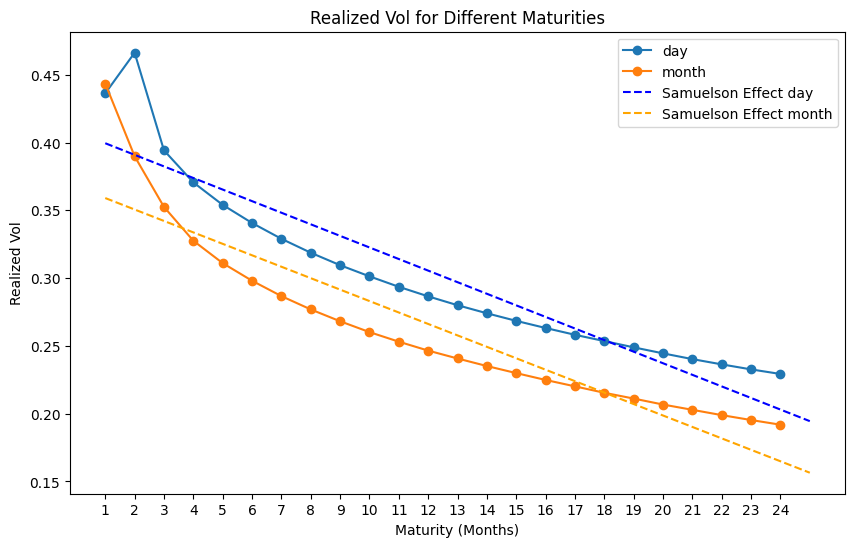

In [ ]:
# Fit a linear regression model to the volatility values
betas1 = []
alphas1 = []
for column in realized_vol.columns:
    X = np.arange(1, 25)  # Maturity in monthsday
    y = realized_vol[column].values

    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)

    # Calculate the Samuelson effect measure
    betas1.append(model.coef_[0])
    alphas1.append(model.intercept_)
    print(f"Samuelson effect measure for {column}ly basis: {model.coef_[0]:.6f}")

maturities = range(1, 25)
plt.figure(figsize=(10, 6))

# Plot each column with a different line style
plt.plot(maturities, realized_vol, marker = 'o', label=realized_vol.columns)

# Set labels and title
plt.xlabel('Maturity (Months)')
plt.ylabel('Realized Vol')
plt.title('Realized Vol for Different Maturities')

# Add regression line to the plot
x = np.linspace(1, 25, 25)  # Adjust x to reflect monthly maturities
y1 = betas1[0] * x + alphas1[0]
y2 = betas1[1] * x + alphas1[1]

plt.plot(x, y1, color='Blue', linestyle='--', label ="Samuelson Effect day")
plt.plot(x, y2, color='Orange', linestyle='--', label ="Samuelson Effect month")
plt.legend(loc='upper right')
plt.xticks(maturities)

plt.legend(loc='best')

plt.show()

### Average Volatility Gradient across all maturities:
This will provide a single measure that represents the average change in volatility per step increase in contract maturity. A negative value indicates support for the Samuelson effect.


In [ ]:
# Calculate the percentage change between consecutive columns
pct_changes = realized_vol.pct_change(axis=0)
# Calculate the mean of these percentage changes
average_volatility_gradient = pct_changes.mean(axis=1)

print("Average Volatility Gradient across all maturities:")
print(average_volatility_gradient)

Average Volatility Gradient across all maturities:
Date
NYM-LIGHT CRUDE OIL TRc1          NaN
NYM-LIGHT CRUDE OIL TRc2    -0.026036
NYM-LIGHT CRUDE OIL TRc3    -0.125183
NYM-LIGHT CRUDE OIL TRc4    -0.065369
NYM-LIGHT CRUDE OIL TRc5    -0.047603
NYM-LIGHT CRUDE OIL TRc6    -0.039750
NYM-LIGHT CRUDE OIL TRc7    -0.036160
NYM-LIGHT CRUDE OIL TRc8    -0.032721
NYM-LIGHT CRUDE OIL TRc9    -0.030208
NYM-LIGHT CRUDE OIL TRc10   -0.028209
NYM-LIGHT CRUDE OIL TRc11   -0.026412
NYM-LIGHT CRUDE OIL TRc12   -0.024993
NYM-LIGHT CRUDE OIL TRc13   -0.023189
NYM-LIGHT CRUDE OIL TRc14   -0.022192
NYM-LIGHT CRUDE OIL TRc15   -0.021323
NYM-LIGHT CRUDE OIL TRc16   -0.020774
NYM-LIGHT CRUDE OIL TRc17   -0.020026
NYM-LIGHT CRUDE OIL TRc18   -0.019750
NYM-LIGHT CRUDE OIL TRc19   -0.019015
NYM-LIGHT CRUDE OIL TRc20   -0.019359
NYM-LIGHT CRUDE OIL TRc21   -0.018125
NYM-LIGHT CRUDE OIL TRc22   -0.017708
NYM-LIGHT CRUDE OIL TRc23   -0.016925
NYM-LIGHT CRUDE OIL TRc24   -0.016102
dtype: float64


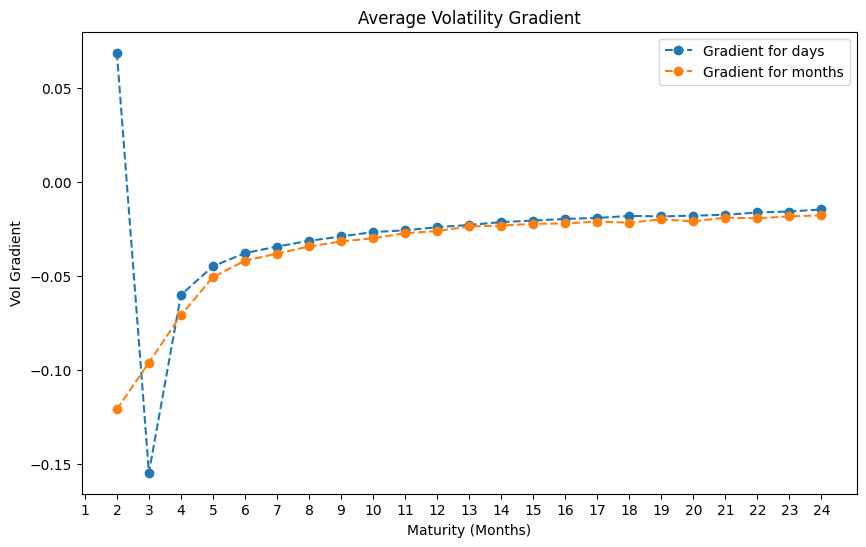

In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot each column
plt.plot(maturities, pct_changes, linestyle='--', marker = 'o', label=["Gradient for days", "Gradient for months"])
plt.xlabel('Maturity (Months)')
plt.ylabel('Vol Gradient')
plt.title('Average Volatility Gradient')
plt.xticks(maturities)  # Set the x-axis ticks to be maturities
plt.legend(loc='best')
plt.savefig("AvVolGrad.png")
plt.show()

#  Characteristics of the time series of model parameters obtained in Step 2

In [ ]:
# Definition of dates to be tested
dates = future_last_days.index.unique()
dates

DatetimeIndex(['2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31',
               '2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31',
               '2013-08-31', '2013-09-30',
               ...
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31'],
              dtype='datetime64[ns]', name='Date', length=131, freq='M')

## Model 1Factor

We proceed by doing a visual representation

In [ ]:
#Calculate mean sigma and mean alpha

# sigma_cal
mean_sigma_cal = np.mean(calibrated_sigmas)

# alpha_cal
mean_alpha_cal = np.mean(calibrated_alphas)

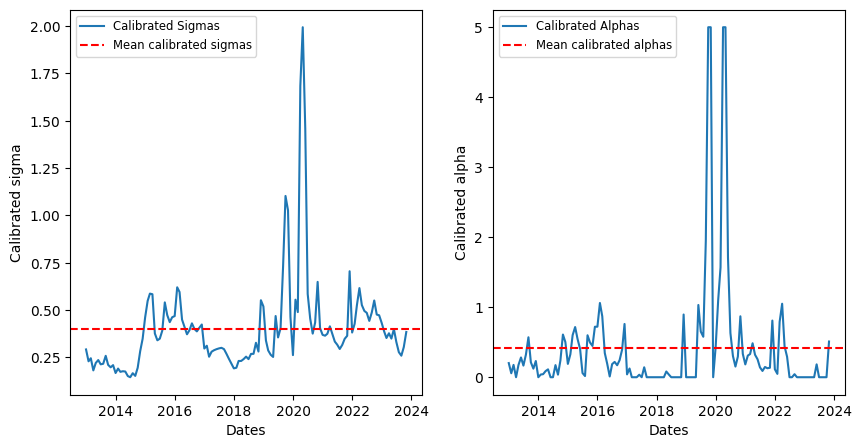

In [ ]:
# Plot sigma and alpha side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot sigma
ax1.plot(dates, calibrated_sigmas, label = "Calibrated Sigmas")
ax1.set_xlabel('Dates')
ax1.set_ylabel('Calibrated sigma')

# Add mean line to the plot
ax1.axhline(y=mean_sigma_cal, color='r', linestyle='--', label = "Mean calibrated sigmas")

# Plot alpha
ax2.plot(dates, calibrated_alphas, label = "Calibrated Alphas")
ax2.set_xlabel('Dates')
ax2.set_ylabel('Calibrated alpha')

# Add mean line to the plot
ax2.axhline(y=mean_alpha_cal, color='r', linestyle='--', label = "Mean calibrated alphas")

ax1.legend(loc='upper left', fontsize = "small")
ax2.legend(loc='upper left', fontsize = "small")

plt.show()

## Model 2Factor

In [ ]:
#Calculate mean sigma and mean alpha

# sigma1_cal
mean_sigma1_cal = np.mean(calibrated_sigma1)

# alpha1_cal
mean_alpha1_cal = np.mean(calibrated_alpha1)

# sigma2_cal
mean_sigma2_cal = np.mean(calibrated_sigma2)

# alpha2_cal
mean_alpha2_cal = np.mean(calibrated_alpha2)

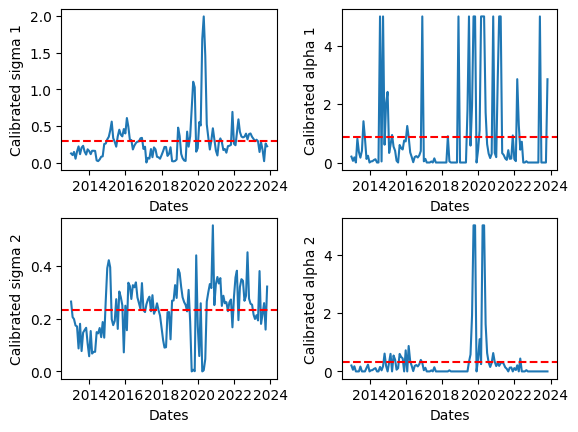

In [ ]:
# Create a grid of 2x2 subplots
gs = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.3)

# Plot sigma 1
plt.subplot(gs[0, 0])
plt.plot(dates, calibrated_sigma1)
plt.xlabel('Dates')
plt.ylabel('Calibrated sigma 1')
plt.axhline(y=mean_sigma1_cal, color='r', linestyle='--')

# Plot alpha 1
plt.subplot(gs[0, 1])
plt.plot(dates, calibrated_alpha1)
plt.xlabel('Dates')
plt.ylabel('Calibrated alpha 1')
plt.axhline(y=mean_alpha1_cal, color='r', linestyle='--')

# Plot sigma 2
plt.subplot(gs[1, 0])
plt.plot(dates, calibrated_sigma2)
plt.xlabel('Dates')
plt.ylabel('Calibrated sigma 2')
plt.axhline(y=mean_sigma2_cal, color='r', linestyle='--')

# Plot alpha 2
plt.subplot(gs[1, 1])
plt.plot(dates, calibrated_alpha2)
plt.xlabel('Dates')
plt.ylabel('Calibrated alpha 2')
plt.axhline(y=mean_alpha2_cal, color='r', linestyle='--')

plt.show()